In [1]:
%load_ext autoreload
%autoreload 2
import waffles
import numpy as np
import json
import shutil 
from tqdm import tqdm

from waffles.data_classes.Waveform import Waveform
from waffles.data_classes.WaveformSet import WaveformSet
from waffles.data_classes.UniqueChannel import UniqueChannel
from waffles.data_classes.ChannelWsGrid import ChannelWsGrid
from waffles.np02_utils.AutoMap import generate_ChannelMap, dict_uniqch_to_module, dict_module_to_uniqch
from waffles.np02_utils.PlotUtils import plot_grid, plot_detectors, genhist, runBasicWfAnaNP02, runBasicWfAnaNP02Updating
from waffles.coldboxVD.utils.spybuffer_reader import create_waveform_set_from_spybuffer


from waffles.data_classes.CalibrationHistogram import CalibrationHistogram
from waffles.plotting.plot import plot_ChannelWsGrid, plot_CustomChannelGrid
from waffles.plotting.plot import plot_CalibrationHistogram
from waffles.utils.fit_peaks.fit_peaks import fit_peaks_of_CalibrationHistogram


In [15]:
filepath_folder = "/eos/experiment/neutplatform/protodune/experiments/ColdBoxVD/November2025run/spy_buffer/LED_scan/"
# filepath_folder = "/eos/experiment/neutplatform/protodune/experiments/ColdBoxVD/November2025run/spy_buffer/noise/vgain_scan_membrane_noise_n5V_below_Vbr_02122025_afternoon/vgain_1000/"
wfset_full = None

channel_to_load = [ 28, 29, 30, 31 ]
led_values = [ 11 , 11, 14, 14]

for channel, volt in zip(channel_to_load, led_values):
    filepath_folder = f"/eos/experiment/neutplatform/protodune/experiments/ColdBoxVD/November2025run/spy_buffer/LED_scan/{volt}V/"
    filename=filepath_folder+f"channel_{channel}.dat"
    wfset_tmp = create_waveform_set_from_spybuffer(filename=filename, WFs=20000, length=1024, config_channel=channel)
    if wfset_full is None:
        wfset_full = wfset_tmp
    else:
        wfset_full.merge(wfset_tmp)

The file has been correctly read
The file has been correctly read
The file has been correctly read
The file has been correctly read


In [16]:
from plotly import graph_objects as go
import yaml
from waffles.np02_utils.AutoMap import strUch
from waffles.np02_utils.PlotUtils import __update_dict

import waffles.Exceptions as we

def runBasicWfAnaNP02Updating(wfset: WaveformSet, updatethreshold:bool, show_progress: bool, params: dict = {}, configyaml = "", doprocess:bool = True, onlyoptimal=True):
    endpoint = wfset.waveforms[0].endpoint
    channel = wfset.waveforms[0].channel
    
    if endpoint not in params or channel not in params[endpoint]:
        print(f"No parameters found for endpoint {endpoint} and channel {channel} in the configuration file.")

    if(len(wfset.available_channels[list(wfset.runs)[0]][endpoint]) > 1):
        raise ValueError(f"Should have only one channel in the waveform set...")

    if updatethreshold:
        run = list(wfset.runs)[0]
        dictbaseline = params[endpoint][channel]['baseline']
        dictfit = params[endpoint][channel]['fit']
        if run in params['updates'][endpoint][channel]:
            dictupdate = params['updates'][endpoint][channel][run]
            __update_dict(dictbaseline, dictupdate, 'threshold')
            __update_dict(dictbaseline, dictupdate, 'default_filtering')
            __update_dict(dictfit, dictupdate, 'bins_int')
            __update_dict(dictfit, dictupdate, 'domain_int')
            __update_dict(dictfit, dictupdate, 'max_peaks')
            __update_dict(dictfit, dictupdate, 'prominence')
            __update_dict(dictfit, dictupdate, 'half_point_to_fit')
    
    if doprocess:
        runBasicWfAnaNP02(wfset,
                          int_ll=params[endpoint][channel]['fit'].get('int_ll', 254),
                          int_ul=params[endpoint][channel]['fit'].get('int_ul', 270),
                          amp_ll=params[endpoint][channel]['fit'].get('amp_ll', 254),
                          amp_ul=params[endpoint][channel]['fit'].get('amp_ul', 270),
                          show_progress=show_progress,
                          onlyoptimal=onlyoptimal,
                          configyaml=params
                          )


def fithist(wfset:WaveformSet, figure:go.Figure, row, col, wf_func = {}):
    doprocess = wf_func.get("doprocess", True)
    dofit = wf_func.get("dofit", True)
    normalize_hist = wf_func.get("normalize_hist", False)
    variable = wf_func.get('variable', 'integral')
    show_progress = wf_func.get('show_progress', False)
    fitmultigauss = wf_func.get('fitmultigauss', False)
    fit_type:str = 'independent_gaussians'
    if fitmultigauss:
        fit_type = wf_func.get('fit_type', 'multigauss_iminuit')
    verbosemultigauss = wf_func.get('verbosemultigauss', False)
    with open("./coldbox_ch_snr_parameters.yaml") as f:
        params = yaml.safe_load(f)
    endpoint = wfset.waveforms[0].endpoint
    channel = wfset.waveforms[0].channel

    if endpoint not in params or channel not in params[endpoint]:
        params[endpoint] = {channel: {'fit': {}, 'baseline': {}}}
        print(f"No parameters found for endpoint {endpoint} and channel {channel} in the configuration file.")

    if(len(wfset.available_channels[list(wfset.runs)[0]][endpoint]) > 1):
        raise ValueError(f"Should have only one channel in the waveform set...")

    update_threshold = wf_func.get("update_threshold", False)
    
    # params get updated inide here
    runBasicWfAnaNP02Updating(
        wfset,
        updatethreshold=update_threshold,
        show_progress=show_progress,
        params=params,
        doprocess=doprocess,
        onlyoptimal=wf_func.get("onlyoptimal", True)
    )

    bins_int = params[endpoint][channel]['fit'].get('bins_int', 100)
    domain_int_str = params[endpoint][channel]['fit'].get('domain_int', [-10e3, 100e3])
    histautorange = wf_func.get('histautorange', False)


    domain_int = [float(x) for x in domain_int_str]
    domain_int = np.array(domain_int)
    if 'bins' in wf_func:
        tbins = wf_func['bins']
        bins_int = len(tbins)
        domain_int = np.array([tbins[0], tbins[-1]])

    max_peaks = params[endpoint][channel]['fit'].get('max_peaks', 3)
    prominence = params[endpoint][channel]['fit'].get('prominence', 0.15)
    half_point_to_fit = params[endpoint][channel]['fit'].get('half_point_to_fit', 2)
    initial_percentage = params[endpoint][channel]['fit'].get('initial_percentage', 0.15)
    percentage_step = params[endpoint][channel]['fit'].get('percentage_step', 0.05)
    
    if histautorange:
        chargevalues = np.array([wf.analyses["std"].result[variable] for wf in wfset.waveforms if wf.analyses["std"].result[variable] is not np.nan])
        if chargevalues.size == 0:
            print(f"No valid charge values for endpoint {endpoint} and channel {channel}. Skipping histogram generation.")
            return
        domain_int=np.quantile(chargevalues, [0.02, 0.98])
        if len(chargevalues) < 5:
            domain_int = np.array([np.min(chargevalues), np.max(chargevalues)])
        bins_int = 200
    try:
        hInt = CalibrationHistogram.from_WaveformSet(
            wfset,
            bins_number=bins_int,
            domain=domain_int,
            variable=variable,
            analysis_label = "std",
            normalize_histogram=normalize_hist
        )
    except we.EmptyCalibrationHistogram as ehe:
        print(f"EmptyCalibrationHistogram for endpoint {endpoint} and channel {channel}: {ehe}")
        print("Changing range and binning..")
        # repating it.... not the best
        chargevalues = np.array([wf.analyses["std"].result[variable] for wf in wfset.waveforms if wf.analyses["std"].result[variable] is not np.nan])
        print(chargevalues)
        if len(chargevalues) == 0:
            print(f"No valid charge values for endpoint {endpoint} and channel {channel}. Skipping histogram generation.")
            return
        domain_int=np.quantile(chargevalues, [0.02, 0.98])
        if len(chargevalues) < 5:
            domain_int = np.array([np.min(chargevalues), np.max(chargevalues)])
        if len(chargevalues[(chargevalues >= domain_int[0]) & (chargevalues <= domain_int[1])]) < 1:
            print(f"Not enough entries in the charge values for endpoint {endpoint} and channel {channel}. Skipping histogram generation.")
            return
        hInt = CalibrationHistogram.from_WaveformSet(
            wfset,
            bins_number=200,
            domain=domain_int,
            variable=variable,
            analysis_label = "std",
            normalize_histogram=normalize_hist
        )

    if not dofit:
        plot_CalibrationHistogram(
            hInt,
            figure=figure,
            row=row, col=col,
            plot_fits=False,
            name=f"{dict_uniqch_to_module.get(str(UniqueChannel(wfset.waveforms[0].endpoint, wfset.waveforms[0].channel)), '')}",
        )
        if wf_func.get("log_y", False):
            figure.update_yaxes(type="log")
        return

    # This method in case histogram should cut average
    # average_hits = hInt.edges[:-1]*hInt.counts
    # average_hits = np.sum(average_hits)/np.sum(hInt.counts)

    # This method in case histogram should not cut average
    integral_sum = np.nansum( np.array([ wf.analyses["std"].result[variable] for wf in wfset.waveforms ]) )
    n_integrals = np.sum( [1 if wf.analyses["std"].result[variable] is not np.nan else 0 for wf in wfset.waveforms ] )
    average_hits = integral_sum / n_integrals if n_integrals > 0 else 0

    fit_hist = fit_peaks_of_CalibrationHistogram(
        hInt,
        max_peaks          = max_peaks,
        prominence         = prominence,
        initial_percentage = initial_percentage,
        half_points_to_fit  = half_point_to_fit,
        percentage_step    = percentage_step,
        fit_type=fit_type
    )
    if verbosemultigauss:
        print(getattr(hInt, "iminuit", None))
    fit_params = hInt.gaussian_fits_parameters

    zero_charge = 0
    spe_charge = 0
    baseline_stddev = 0
    spe_stddev = 0

    gain = 0
    snr = 0
    errgain=0
    try:
        zero_charge = fit_params['mean'][0][0]
        zero_charge_err = fit_params['mean'][0][1]
        spe_charge = fit_params['mean'][1][0]
        spe_charge_err = fit_params['mean'][1][1]
        baseline_stddev = abs(fit_params['std'][0][0])
        spe_stddev = fit_params['std'][1][0]

        gain = spe_charge - zero_charge
        errgain = np.sqrt( zero_charge_err**2 + spe_charge_err**2 )
        mm = getattr(hInt, "iminuit", None)
        if mm is not None:
            errgain = hInt.iminuit.params[3].error
        snr = gain / baseline_stddev
    except:
        print(f"Could not fit for {dict_uniqch_to_module.get(str(UniqueChannel(wfset.waveforms[0].endpoint, wfset.waveforms[0].channel)),'')}")

    plot_CalibrationHistogram(
        hInt,
        figure=figure,
        row=row, col=col,
        plot_fits=True,
        name=f"{wfset.waveforms[0].endpoint - wfset.waveforms[0].channel}; snr={snr:.2f}",
        showfitlabels=False,
    )
    if wf_func.get("log_y", False):
        figure.update_yaxes(type="log", range=[-1, np.log10(np.max(hInt.counts)*2) ], row=row, col=col)

    if snr != 0:
        for wf in wfset.waveforms:
            wf.analyses["std"].result['snr'] = snr
            wf.analyses["std"].result['normalization'] = hInt.normalization
            wf.analyses["std"].result['gain'] = gain
            wf.analyses["std"].result['errgain'] = errgain
        print(
            f"{list(wfset.runs)[0]},",
            # f"{dict_uniqch_to_module[str(UniqueChannel(wfset.waveforms[0].endpoint, wfset.waveforms[0].channel))]},",
            f"{endpoint},",
            f"{channel},",
            f"{snr:.2f},",
            f"{gain:.2f},",
            f"{baseline_stddev:.2f},",
            f"{spe_stddev:.2f},",
            f"{average_hits/gain:.2f}",
        )


In [ ]:
histargs = dict(    
    doprocess = True,
    dofit = True,
    variable = 'integral',
    show_progress = True,
    fitmultigauss=True,
    normalize_hist=False,
    onlyoptimal=True,
)

detector=[ UniqueChannel(10, x) for x in channel_to_load ]
#detector=[UniqueChannel(10,28)]
plot_detectors(wfset_full, detector, plot_function=fithist, html=None, wf_func=histargs)

Processing waveform set with BasicWfAna


100%|██████████| 10000/10000 [00:01<00:00, 6791.45it/s]


0, 10, 28, 2.99, 1337.43, 447.13, 447.13, 1.37


In [36]:
argsheat = dict(
    mode="heatmap",
    analysis_label="std",
    adc_range_above_baseline=200,
    adc_range_below_baseline=-50,
    adc_bins=125,
    time_bins=wfset_full.points_per_wf//2,
    filtering=4,
    share_y_scale=False,
    share_x_scale=True,
    wfs_per_axes=5000,
    zlog=True
)
detector=detector
plot_detectors(wfset_full, detector, **argsheat)


In [12]:
import matplotlib.pyplot as plt
wftest = ChannelWsGrid.clusterize_waveform_set(wfset_full)


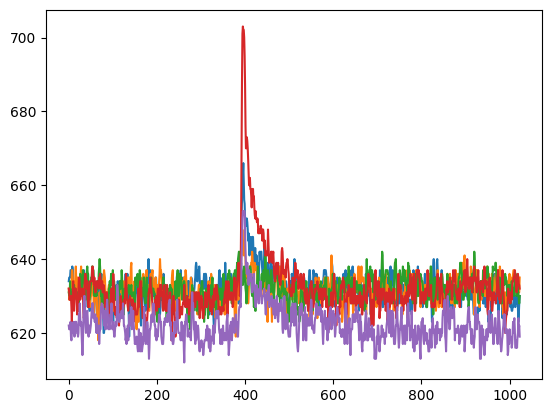

In [13]:
for it in range(5):
    wf = wftest[10][8].waveforms[it]
    # wf = wfset.waveforms[it]
    plt.plot(wf.adcs)

In [14]:
# detectors=["M7(1)", "M7(2)", "M8(1)", "M8(2)"]
detectors=["C6(1)", "C6(2)"]

run = 38577
def get_channels(waveform:Waveform, detectors:list) -> bool:
    if dict_uniqch_to_module[str(UniqueChannel(waveform.endpoint, waveform.channel))] in detectors:
        return True
    return False

if nwaveforms is not None:
    wfset_tmp = open_processed(run, dettype, output_dir, nwaveforms=None)
else:
    wfset_tmp = wfset
wfset_fit = WaveformSet.from_filtered_WaveformSet(wfset_tmp, get_channels, detectors=detectors)

NameError: name 'nwaveforms' is not defined

In [ ]:
detectors_x = [ d.replace("(","_").replace(")","") for d in detectors]
html = Path(f"./snr_plots/run{run:06d}_{dettype}_{'_'.join(detectors_x)}.html")
html.parent.mkdir(parents=True, exist_ok=True)
html

fithistargs = dict(
    # doprocess=False, 
    show_progress=True
)

setupargs=dict(
# default 1000x800
    width=1000,
    height=800
)
print("Run, Module, snr, gain, baseline std dev, 1pe std dev, integral_mean_in_pe")
plot_detectors(wfset_fit, detectors, plot_function=fithist, html=html, showplots=True, wf_func=fithistargs, **setupargs)

wfch_fit = ChannelWsGrid.clusterize_waveform_set(wfset_fit)
print("By channel..")
for ep, v in wfch_fit.items():
    print("Endpoint:", ep)
    for ch, wfs in v.items():
        ngoodwaves = [ 1 if wfs.analyses['std'].result['integral'] is not np.nan else 0 for wfs in wfs.waveforms ]
        print(f"Ch: {ch}, {np.sum(ngoodwaves)}, total: {len(wfch_fit[ep][ch].waveforms)}")